# Vstar_reduc example

This is a basic image reduction script based on the data processing techniques taught in the physics 2070 course and York university that were previously carried through with IRAF. This script aims to be the first of many demonstrations of a more automatic system that still retains full user control and more education value than just clicking a button. 


## Declaring file prefixes and locations

Here are the standard file prefixes for this reduction script. Data was taken in 8 band filters in December of 2018 of comet 46P Wirtanen (4 filters are clear). Along with 'lights', 'flats' and 'bias' images were taken for reduction.

In [1]:
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

START_DATE_TIME = datetime.datetime.now()

print('\nStarting time: ', START_DATE_TIME)

# D:/draco_data/2019-08-23+24
# C:/Users/mucep/Offline/2018-12-04+05
# D:/draco_data/2019-01-13+14
directory = 'C:/Users/mucep/Offline/2018-12-04+05'
star = 'BL-Cam'
filename = 'DYPEG'
home_dir = os.getcwd()
print('\nHome dir: ', home_dir)

BIAS_suffix = '.BIAS'
FLAT_prefix = 'FLAT_'
FLAT_suffix = '.FLAT'

filters = ['BLUE', 'CLEAR', 'EIGHT', 'GREEN', 'LUMINANCE', 'RED', 'SEVEN', 'SIX']



Starting time:  2019-09-13 14:46:45.371481

Home dir:  C:\Users\mucep\OneDrive\Documents\GitHub\DRACO


## Imports

The first aspect of every script is importing the external code that the script will 'call to'. These are known as import statements. First we import the main Draco file and then we import the Table and fits libraries from astropy. Next we import the two most fundamental libraries for anything science or computing related in python, numpy and matplotlib.

In [2]:
import draco
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

from astropy.nddata import CCDData
from ccdproc import Combiner
import ccdproc
import astropy.units as u
from astropy.utils.misc import isiterable


## Opening the Bias into memory
Here we will scan the selected directory for files and separate them into lists of Bias' images, Flat images, and Light images. Then we will open the Bias' images into memory.

In [3]:
bias_list, flats_list, lights_list = draco.checkdir(directory)
bias, bias_headers = draco.get_series(directory, bias_list)


dirlist:  124

bias':  10

flats:  10

lights:  104

total:  124


## Making the master BIAS

Making a master bias image in DRACO is as easy as one line. By feeding the `draco.mast_reduc` function the folder location of the BIAS images, the filename prefix (text before the index numbers), the filename suffix (text after the index numbers), the number of BIAS images taken, and a Boolean value of whether or not to edit out cosmic rays from the BIAS images before stacking (takes extra time to compute), draco will return the master BIAS image which we store as `master_bias`.

By uncommenting the second line will write the master BIAS image to a fits file in the scripts home folder. Future versions of DRACO will better handle file input/output.


(1023, 1536, 10)
463.92218


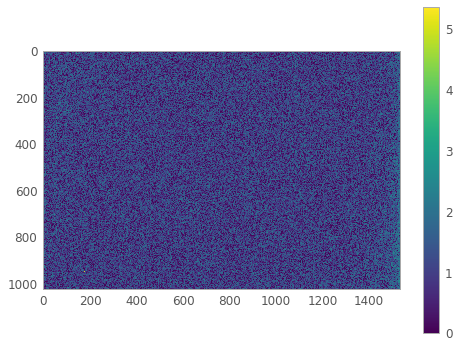

In [4]:
master_bias = draco.mast_reduc(bias)
#fits.writeto('master_bias.fits', master_bias)
print(np.mean(master_bias))
draco.plt_bias(np.arcsinh(np.abs(master_bias-np.mean(master_bias))), 'viridis')

## Setting up the FLATS in memory



In [5]:
size = master_bias.shape
master_i_Flat = []
flats, flat_headers = draco.get_series(directory, flats_list)

## Reading and reducing the FLATS into Master FLATS




Starting flat reduction
(1023, 1536, 10)
(1023, 1536)
reduced flat: 


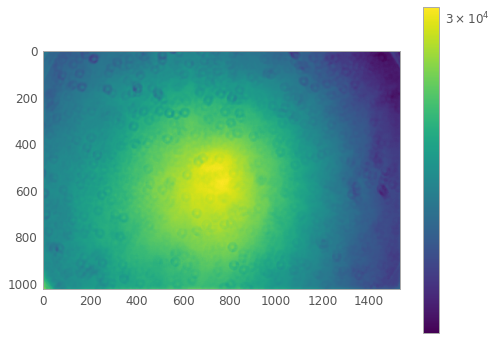

norm_factor:  [26346.16999817]


In [6]:
print('\nStarting flat reduction')
flat = draco.mast_flat(flats, master_bias)
flat = draco.norm_flat(np.array((flat.data)))
#fits.writeto('master_' + reduc_filters[i] + '_Flat.fits', master_i_Flat[i])


## Reading and reducing the LIGHTS into Fully Reduced LIGHTS



In [7]:
series, headers = draco.get_series(directory, lights_list)
series = draco.series_arith(series, '-', master_bias, series.shape[2])
series = draco.series_arith(series, '/', flat, series.shape[2])
sky = draco.sky_est(series)
series = draco.series_arith(series, '-', sky, series.shape[2])

# combine_list = []
# for t in range(series.shape[2]):
#     combine_list.append(CCDData(series[:, :, t], unit=u.adu))
# combine = Combiner(combine_list)
# reduced_nocr = combine.average_combine()
# reduced = reduced_nocr # ccdproc.cosmicray_lacosmic(reduced_nocr)

# sample = np.log(np.abs(reduced))
# draco.plt_fits(sample, 'viridis')

print('\nLight reduction complete.')


Light reduction complete.


## Plotting a sample image



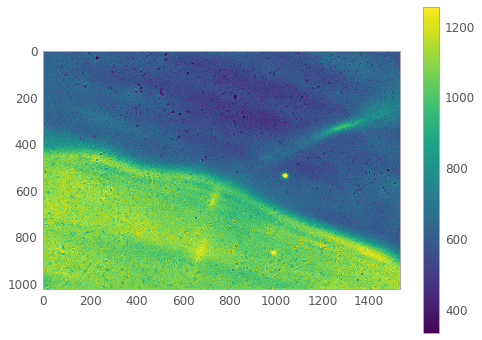

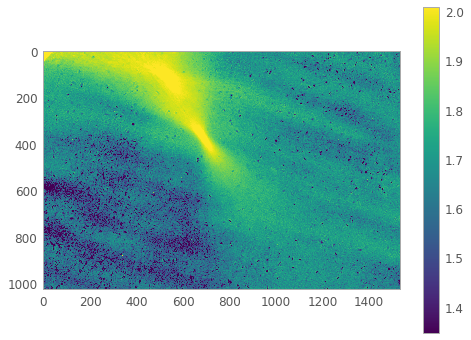

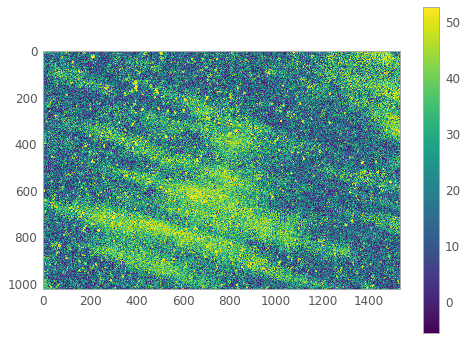

In [8]:
sample_star_field = series[:, :, 50]
sample_star_field2 = np.log(np.arcsinh(np.abs(series[:, :, 70])))
sample_star_field3 = np.arcsinh(np.log(np.abs(series[:, :, 74])))**(5)
search_star_field = series[:, :, 10]
draco.plt_fits(sample_star_field, 'viridis')
draco.plt_fits(sample_star_field2, 'viridis')
draco.plt_fits(sample_star_field3, 'viridis')



Staring star identification...

Number of stars:  623

Starting ploting...



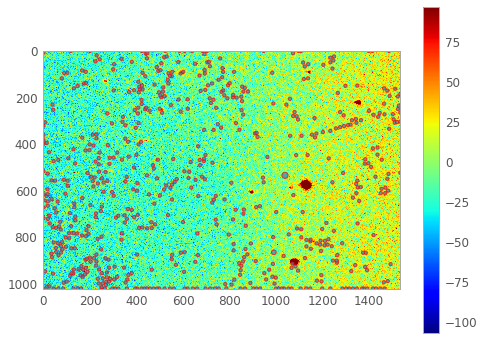

In [9]:
print('\nStaring star identification...')
x, y, r, opt_img = draco.starSeeker2(sample_star_field)
print('\nNumber of stars: ', len(x))
print('\nStarting ploting...\n')
draco.plt_stars(series[:, :, 10], x, y, r)

In [10]:
os.chdir(home_dir)

END_DATE_TIME = datetime.datetime.now()

In [11]:
print('\nEnding time: ', END_DATE_TIME)
print("Time elapsed: ", (END_DATE_TIME - START_DATE_TIME))



Ending time:  2019-09-13 14:49:23.186194
Time elapsed:  0:02:37.814713


In [12]:
# plt_ser = np.exp2(np.log(reduced))
# draco.plt_fits(plt_ser, 'gray')